# Introduction to text embeddings on S&P 500 news

objectives# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [ ]:
%pip install pandas
%pip install yfinance
%pip install lxml
%pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

## Get the list of stocks in the S&P 500

In [65]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

display(df_tickers.head())

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [77]:
ticker_list = df_tickers['Symbol'].tolist()

In [84]:
ticker_list

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADBE',
 'AMD',
 'AES',
 'AFL',
 'A',
 'APD',
 'ABNB',
 'AKAM',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'AON',
 'APA',
 'APO',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'TECH',
 'BIIB',
 'BLK',
 'BX',
 'XYZ',
 'BK',
 'BA',
 'BKNG',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'BLDR',
 'BG',
 'BXP',
 'CHRW',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'COR',
 'CNC',
 'CNP',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'COIN',
 'CL',
 'CMCSA',
 'CAG',
 'COP',
 'ED',
 'STZ',
 'CEG',


## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [ ]:
# Create a dictionary where the keys are the symbols (tickers) of each 500 stocks
# and the value is the output news from the yfinance library

sp_news = {}

for ticker in ticker_list:
      stock = yf.Ticker(ticker)
      sp_news[ticker] = stock.news

### Structure the news into a pandas dataframe

Your final dataframe should have the following columns:
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

## Create a news Dataframe

In [78]:
rows = []

for ticker, news in sp_news.items():
    for article in news:
        content = article.get('content', False)
        if content:
          rows.append({
              'TICKER': ticker,
              'TITLE': content.get('title', ''),
              'SUMMARY': content.get('summary', ''),
              'PUBLICATION_DATE': content.get('pubDate', ''),
              'URL': content.get('canonicalUrl', '')['url']
          })

In [79]:
sp_index_df = pd.DataFrame(rows)
sp_index_df.head()

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24T09:03:00Z,https://finance.yahoo.com/news/3m-company-mmm-...
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21T09:45:00Z,https://finance.yahoo.com/news/zacks-industry-...
2,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21T08:22:00Z,https://finance.yahoo.com/news/stock-market-ne...
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19T07:05:47Z,https://finance.yahoo.com/news/3m-co-mmm-q2-20...
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19T05:30:58Z,https://finance.yahoo.com/news/mmm-q1-deep-div...


## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT


In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

## Get the title embeddings

In [82]:
sp_index_df['EMBEDDED_TEXT'] = sp_index_df['TITLE']
sp_index_df['EMBEDDINGS'] = sp_index_df['EMBEDDED_TEXT'].apply(lambda x: model.encode(x))

In [83]:
sp_index_df[['TICKER', 'EMBEDDED_TEXT', 'EMBEDDINGS']].head()

,TICKER,EMBEDDED_TEXT,EMBEDDINGS
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,"[0.006455397, -0.10904753, -0.0799597, 0.02607..."
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","[-0.021629294, -0.079783216, -0.025434935, 0.0..."
2,MMM,"Stock Market News for Jul 21, 2025","[-0.037469573, -0.04381371, 0.023525972, 0.107..."
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,"[-0.08080151, -0.029800776, -0.03165097, 0.046..."
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,"[-0.019502636, -0.072803885, 0.044423085, -0.0..."


## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

## Keep only one news for each company

In [85]:
sp_df_simplified = sp_index_df.drop_duplicates(subset='TICKER').copy()
sp_df_simplified.head()

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24T09:03:00Z,https://finance.yahoo.com/news/3m-company-mmm-...,3M Company (MMM): “I Was Surprised” By The Org...,"[0.006455397, -0.10904753, -0.0799597, 0.02607..."
10,AOS,A.O. Smith: Q2 Earnings Snapshot,"On a per-share basis, the Milwaukee-based comp...",2025-07-25T11:03:06Z,https://finance.yahoo.com/news/o-smith-q2-earn...,A.O. Smith: Q2 Earnings Snapshot,"[-0.07597604, 0.053140637, -0.040493164, 0.058..."
20,ABT,Oversold Abbott Laboratories (ABT) Could Offer...,Abbott Laboratories (NYSE:ABT) is included amo...,2025-07-26T03:50:16Z,https://finance.yahoo.com/news/oversold-abbott...,Oversold Abbott Laboratories (ABT) Could Offer...,"[-0.0776894, -0.048019197, 0.009659035, 0.0101..."
30,ABBV,"Mag 7 earnings, Fed meeting, PCE, jobs report:...",Market Domination Overtime host Josh Lipton go...,2025-07-25T23:00:20Z,https://finance.yahoo.com/video/mag-7-earnings...,"Mag 7 earnings, Fed meeting, PCE, jobs report:...","[-0.037060283, -0.08999145, -0.0060009426, 0.1..."
40,ACN,Accenture’s (ACN) Oversold Status May Offer a ...,Accenture plc (NYSE:ACN) is included among the...,2025-07-26T03:44:43Z,https://finance.yahoo.com/news/accenture-acn-o...,Accenture’s (ACN) Oversold Status May Offer a ...,"[-0.078672744, -0.076795004, 0.06404919, 0.047..."


## Apply KMeans

### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

#### Try different values of k and compute silhouette scores

Note: The instrucction is asking to try with 1 cluster but that's and invalid parameter, the minimum value is 2.

In [86]:
embedding_matrix = np.vstack(sp_df_simplified['EMBEDDINGS'].values)
k_values = range(2, 7)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(embedding_matrix)
    score = silhouette_score(embedding_matrix, cluster_labels)
    silhouette_scores.append(score)

In [87]:
embedding_matrix

array([[ 0.0064554 , -0.10904753, -0.0799597 , ..., -0.12938619,
         0.06375781,  0.00975932],
       [-0.07597604,  0.05314064, -0.04049316, ..., -0.08979998,
        -0.04230773,  0.055401  ],
       [-0.0776894 , -0.0480192 ,  0.00965904, ..., -0.18052702,
        -0.00798293,  0.01101425],
       ...,
       [-0.13333325,  0.06265333,  0.03626342, ..., -0.11534588,
         0.02981649,  0.03176272],
       [-0.08531152,  0.03004265, -0.03967028, ..., -0.07048615,
         0.0658238 , -0.01584911],
       [-0.0767046 ,  0.03564042, -0.03869194, ..., -0.12921375,
        -0.01817409,  0.03981116]], dtype=float32)

#### Plot silhouette scores

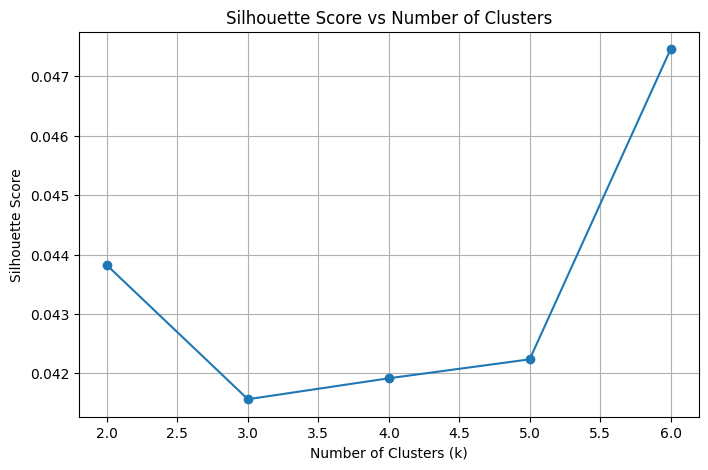

In [88]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

#### Identify the Best k

I will include a code to automatically get the best score from the results:

In [89]:
best_k, best_score = max(zip(k_values, silhouette_scores), key=lambda x: x[1])
print(f"The best k value according to its silhouette score is: {best_k}, with a score of: {best_score:.4f}")

The best k value according to its silhouette score is: 6, with a score of: 0.0475


#### Cluster the embeddings using 3 clusters (k=3)

In [93]:
optimal_kmeans = KMeans(n_clusters=3, random_state=42)
sp_df_simplified['CLUSTER'] = optimal_kmeans.fit_predict(embedding_matrix)

### Visualize the 2 first PCA Components of your embeddings

In [94]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(embedding_matrix)

In [95]:
sp_df_simplified['PCA1'] = pca_components[:, 0]
sp_df_simplified['PCA2'] = pca_components[:, 1]

In [96]:
sp_df_simplified.head()

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS,CLUSTER,PCA1,PCA2
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24T09:03:00Z,https://finance.yahoo.com/news/3m-company-mmm-...,3M Company (MMM): “I Was Surprised” By The Org...,"[0.006455397, -0.10904753, -0.0799597, 0.02607...",0,-0.108249,-0.158192
10,AOS,A.O. Smith: Q2 Earnings Snapshot,"On a per-share basis, the Milwaukee-based comp...",2025-07-25T11:03:06Z,https://finance.yahoo.com/news/o-smith-q2-earn...,A.O. Smith: Q2 Earnings Snapshot,"[-0.07597604, 0.053140637, -0.040493164, 0.058...",2,0.425209,0.034176
20,ABT,Oversold Abbott Laboratories (ABT) Could Offer...,Abbott Laboratories (NYSE:ABT) is included amo...,2025-07-26T03:50:16Z,https://finance.yahoo.com/news/oversold-abbott...,Oversold Abbott Laboratories (ABT) Could Offer...,"[-0.0776894, -0.048019197, 0.009659035, 0.0101...",1,-0.160195,0.015409
30,ABBV,"Mag 7 earnings, Fed meeting, PCE, jobs report:...",Market Domination Overtime host Josh Lipton go...,2025-07-25T23:00:20Z,https://finance.yahoo.com/video/mag-7-earnings...,"Mag 7 earnings, Fed meeting, PCE, jobs report:...","[-0.037060283, -0.08999145, -0.0060009426, 0.1...",1,0.255620,0.443959
40,ACN,Accenture’s (ACN) Oversold Status May Offer a ...,Accenture plc (NYSE:ACN) is included among the...,2025-07-26T03:44:43Z,https://finance.yahoo.com/news/accenture-acn-o...,Accenture’s (ACN) Oversold Status May Offer a ...,"[-0.078672744, -0.076795004, 0.06404919, 0.047...",1,-0.104055,0.058698


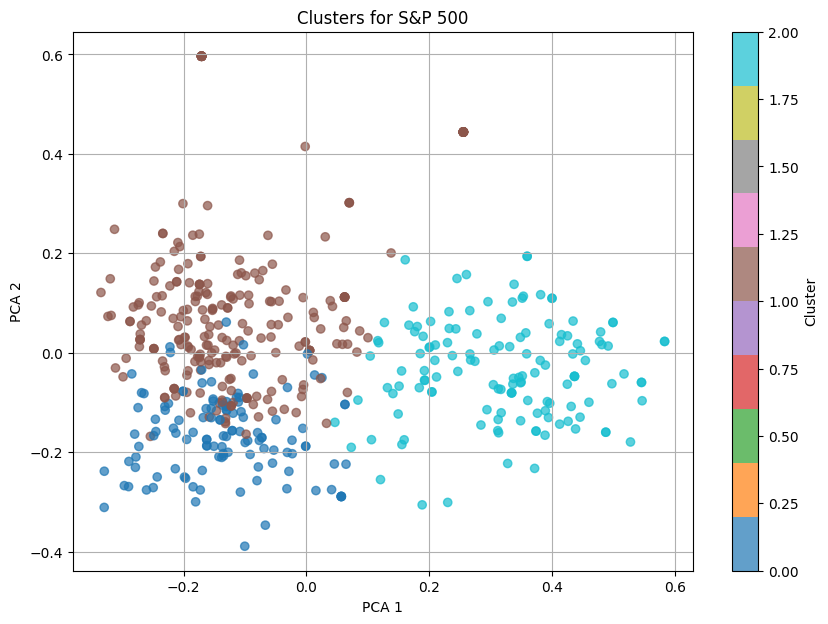

In [97]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(sp_df_simplified['PCA1'], sp_df_simplified['PCA2'],
                      c=sp_df_simplified['CLUSTER'], cmap='tab10', alpha=0.7)
plt.title('Clusters for S&P 500')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [98]:
ticker_to_cluster = dict(zip(sp_df_simplified['TICKER'], sp_df_simplified['CLUSTER']))
sp_index_df['CLUSTER'] = sp_index_df['TICKER'].map(ticker_to_cluster)

In [99]:
for cluster_id in sorted(sp_index_df['CLUSTER'].dropna().unique()):
    print(f"\nCluster {int(cluster_id)}:")
    cluster_data = sp_index_df[sp_index_df['CLUSTER'] == cluster_id]
    sample_titles = cluster_data['TITLE'].dropna().unique()[:20]
    for i, title in enumerate(sample_titles, 1):
        print(f"  {i}. {title}")


Cluster 0:
  1. 3M Company (MMM): “I Was Surprised” By The Organic Growth Rate, Says Jim Cramer
  2. Zacks Industry Outlook Highlights Honeywell, 3M, Carlisle Companies and Federal Signal
  3. Stock Market News for Jul 21, 2025
  4. 3M Co (MMM) Q2 2025 Earnings Call Highlights: Strong EPS Growth Amidst Global Challenges
  5. MMM Q1 Deep Dive: Tariffs Loom Over Stable Operations and Product Launch Momentum
  6. Dow Falls as Trump Reportedly Seeks Higher EU Tariffs; Nasdaq Clinches New High
  7. 3M Gives Investors a ‘Beat and Raise.’ The Stock Is Rising.
  8. Equities Fall Intraday as Trump Reportedly Pushes for Higher Tariffs on EU
  9. US Equity Indexes Slip in Choppy Trading After S&P 500, Nasdaq Composite Scale Fresh Record Highs
  10. 3M (MMM) Stock Trades Down, Here Is Why
  11. Adobe (ADBE) Expands GenStudio with AI Tools for Smarter Ad Creation
  12. Adobe (ADBE) Faces a New Challenge as Figma Pursues $16.4 Billion IPO
  13. CoreWeave vs. Amazon: Which AI Infra Stock Has More Up

**According to the analyzed results, this is the insight I can get for each cluster:**

### Cluster 0 :

This cluster seems to include large industrial and health care companies and how they navigate macroeconomic disruptions.

### Cluster 1:

This clusters includes semiconductors and pharmaceutical sectors, and the topic is mainly strategic innovation

### Cluster 2:

This cluster contains news about investing opportunities in industrial and insurance segments





## Question Section

Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

---

### Technical Understanding

#### 1️⃣ **How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?**

In this case study, the MiniLM model was selected due to its lightweight architecture and computational efficiency, making it particularly suitable for resource-constrained environments such as Google Colab. MiniLM effectively transformed financial news headlines into dense numerical representations known as embeddings, which encode semantic information in a format amenable to clustering algorithms.

Given the pedagogical intent of the exercise, MiniLM offered a pragmatic balance between performance and accessibility. However, for more precise clustering and deeper semantic inference particularly in the context of nuanced financial language larger transformer-based models could be leveraged. These models offer enhanced capacity to capture complex interdependencies between linguistic tokens, though they require significantly greater computational resources.

In sum, MiniLM represented an optimal trade-off for exploratory analysis and concept validation within a learning framework, whereas more sophisticated models would be advisable for high-stakes financial modeling or production-grade applications


---

#### 2️⃣ **What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?**

In the initial configuration of the experiment, clustering was performed using solely the TITLE of each news item. While this approach offers computational efficiency, it poses the risk of semantic underrepresentation, particularly when headlines are ambiguous, overly concise, or fail to reflect the full scope of the article’s content. Consequently, relying exclusively on the title may lead to suboptimal embedding quality and misclassification within the clustering process.

Using only the SUMMARY introduces richer contextual information, potentially enhancing semantic depth and cluster fidelity. However, this method imposes greater computational demands and introduces noise due to the inclusion of less discriminative details. Such variability may dilute the clarity of cluster boundaries, especially in unsupervised settings.

Integrating both TITLE and SUMMARY as a composite feature could strike a beneficial balance. This dual-input approach combines the representational efficiency of the headline with the contextual reinforcement of the summary, potentially improving semantic coherence in the resulting embeddings.

It also increases processing complexity, necessitating more robust model architecture and memory management.

To empirically validate this hypothesis, a revised data preprocessing strategy could be employed merging TITLE and SUMMARY into a unified text field within the dataframe. Subsequent steps would involve re-generating embeddings, reapplying the clustering algorithm, and evaluating any observable improvements in classification and cluster separation.

---

#### 3️⃣ **In what situations would using a different dimensionality reduction method (e.g., t-SNE, UMAP) be preferable over PCA for visualization of embeddings?**

Principal Component Analysis (PCA) is effective for reducing dimensionality in datasets with predominantly linear structures. However, it often fails to capture the intrinsic geometry of complex or nonlinear data distributions, such as those found in images. In contrast, nonlinear techniques like t-SNE and UMAP better preserve local relationships between data points, thereby enabling more natural clustering of nonlinear structures.

Given this, alternative methods should be considered when PCA yields suboptimal results. Even if theoretical limitations are not immediately evident, empirical evaluation of diverse approaches may reveal practical advantages otherwise overlooked.


---

### Data Analysis and Interpretation

#### 4️⃣ **Based on your cluster analysis, identify at least two potential challenges you faced in interpreting the clusters and propose strategies to address them.**

#### 1. Limited Financial Knowledge
Due to a lack of prior experience in finance, interpreting the content and company relevance of news articles proved challenging, potentially leading to misinterpretations of results. To mitigate this, brief background research on each company focusing on its sector and core activities combined with automatic summarization tools can help extract key insights and improve comprehension.

#### 2. Small News Sample Size
Analyzing only 20 articles per cluster may not yield a representative understanding of each group. As a strategy, generating keyword clouds for each cluster could enhance topic identification and offer a clearer thematic overview.

---

#### 5️⃣ **Did you observe any outliers in your 2D visualization? How would you identify and handle these outliers in a production pipeline?**

In the 2D cluster visualization, some seemed outliers. To systematically detect such anomalies in a production pipeline, one could compute the centroid of each cluster and measure the Euclidean distance of individual points from the center. A predefined threshold would then determine which points are considered outliers.

For small datasets, manual inspection can help assess whether these outliers represent noise. However, in automated settings, a conditional rule may be applied: if the number of outliers remains below a specified threshold, they can be discarded as noise; if the count exceeds the limit, these points should be classified into a separate cluster for further analysis.


---

#### 6️⃣ **If you could assign a 'label' or 'theme' to each cluster you obtained, what would they be? How confident are you in these assignments, and what could you do to validate them systematically?**

1. Cluster 0: Macroeconomic disruptions
2. Cluster 1: Strategic innovation
3. Cluster 2: Investing opportunities

However, the reliability of this analysis is limited due to two key factors:
- My lack of financial expertise
- The small sample of news articles used for theme identification

To validate the assigned labels more systematically, the application of Latent Dirichlet Allocation (LDA) was considered. Though I have not previously utilized it, LDA could be applied separately to each cluster to extract one representative topic per group.

---

### Critical Thinking

#### 7️⃣ **If news sentiment was incorporated into the analysis, how might this influence the clustering structure and interpretation of the clusters in a financial analysis context?**

In financial contexts, sentiment analysis can significantly influence the clustering of news articles. While the current approach groups items by thematic content, sentiment whether positive or negative introduces an different criteria that could lead to alternative clustering. For instance, clusters could be labeled by investor mood such as panic, confidence, or uncertainty within a specific sector.

Such sentiment-based grouping would likely reflect broader market emotions rather than company-specific reactions. To capture sentiment at the ticker level, an additional filtering mechanism would be required. Therefore, integrating both thematic and sentiment analyses offers complementary insights: topical clustering identifies prevailing issues, while sentiment analysis signals potential investor responses.


---

#### 8️⃣ **Discuss the limitations of using k-means clustering for news embeddings. What alternative clustering methods could address these limitations, and under what conditions would you prefer them?**


One limitation identified is the need to specify the number of clusters before execution. To address this, additional procedures were implemented, although alternative clustering methods may offer more flexibility.

Another common constraint is sensitivity to outliers, which can distort centroids and negatively affect clustering quality. Additionally, traditional clustering assumes circular cluster shapes, which may not align with the complexity of textual data such as news articles.

To overcome these issues, two alternative methods were explored:

- DBSCAN: Does not require predefining the number of clusters and performs well with noisy data.
- Spectral Clustering: Effectively captures non-linear relationships and is suitable for data with complex structures.


DBSCAN: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

Spectral clustering: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html



#### 9️⃣ **How could the approach in this notebook be extended to analyze the potential impact of news clusters on stock price movements over time? Sketch a high-level pipeline you would implement to test this.**

The approach I propose involves building a pipeline to examine the relationship between news content and the temporal dynamics of stock prices. Using yfinance, historical stock data can be retrieved and matched with existing news articles that are grouped by ticker and publication date.

The process aligns news dates with stock prices both on the same day and over the following five days, capturing short-term impacts. Sentiment analysis (positive/negative) would be incorporated to assess how news tone correlates with price movements.

To quantify the impact, the percentage change in stock price would be calculated relative to the day before the news and across each of the five subsequent days. The average of these changes would represent the potential influence of each news item.

This method provides a ticker-level association between news sentiment and stock performance. For cluster-level evaluation, similar calculations would be performed by averaging price data across all tickers within each cluster, accounting for shared news and timeframes.

Lastly, sentiment trends would be visualized to explore the correlation between positive or negative news and corresponding stock price variations.


---

#### 10️⃣ **Imagine your clustering shows clear groups of news, but your downstream task (e.g., prediction of stock movement) does not improve. What might explain this disconnect between clear clusters and predictive utility?**

The clusters generated in this exercise reflect thematic groupings rather than signals that demonstrate direct correlation with stock prices. This indicates that even if the methodological execution is sound, the chosen analytical approach may lack the capacity to yield the intended outcomes.

Additionally, the complexity of the financial domain and limited data access may restrict the ability to account for all relevant variables. It is also possible that the clusters are overly broad, thereby diluting specific insights and reducing interpretive precision.


